In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import gc
from IPython.display import clear_output

from functools import lru_cache

def sum_2_tuples(a, b):
    return tuple(map(sum, zip(a, b)))

File paths:

In [32]:
LOB_DIR = '../Data_lob/'

TOXIC_BUY_MOMENTS_PATH = '../0_CommonFiles/toxic/toxic_buy_moments_1m_02_06.feather'
TOXIC_SELL_MOMENTS_PATH = '../0_CommonFiles/toxic/toxic_sell_moments_1m_02_06.feather'
TWAP_FILE = './twap.db3'

Experiment details:

In [39]:
# TWAP hedger
volume = 1_000 # in contracts
share_1_hedge = 0.2
twap_interval_seconds = 5

# Read and prepare 'toxic' moments

In [6]:
toxic_buy_moments = pd.read_feather(TOXIC_BUY_MOMENTS_PATH)

In [7]:
toxic_buy_moments_2 = pd.DataFrame(index=toxic_buy_moments['Time']).between_time('10:00', '23:50')

In [8]:
toxic_buy_moments_2

""
Time
2021-02-01 10:01:36.771
2021-02-01 10:05:02.883
2021-02-01 10:05:11.061
2021-02-01 10:05:23.526
2021-02-01 10:07:27.929
...
2021-06-30 19:17:20.554
2021-06-30 19:30:16.189
2021-06-30 19:31:46.414


In [11]:
toxic_buy_moments_2_index = toxic_buy_moments_2.index

In [12]:
toxic_sell_moments = pd.read_feather(TOXIC_SELL_MOMENTS_PATH)

In [13]:
toxic_sell_moments_2 = pd.DataFrame(index=toxic_sell_moments['Time']).between_time('10:00', '23:50')

In [14]:
toxic_sell_moments_2

""
Time
2021-02-01 10:00:09.015
2021-02-01 10:04:36.332
2021-02-01 10:04:57.946
2021-02-01 10:05:19.015
2021-02-01 10:08:27.788
...
2021-06-30 19:03:41.640
2021-06-30 19:05:10.360
2021-06-30 19:05:24.713


In [17]:
toxic_sell_moments_2_index = toxic_sell_moments_2.index

# Functions

In [34]:
class LOBCache:
    def __init__(self):
        pass
    
    def get_lob(self, datetime):
        filename = datetime.strftime('LOB_%m%d.feather')
        return self.__get_lob_by_filename(filename)
        pass
    
    @lru_cache(maxsize=1)
    def __get_lob_by_filename(self, filename):
        print(filename)
        lob = pd.read_feather(LOB_DIR + filename).dropna()
        lob['BID_SIZE10'] = 99_999_999
        lob['ASK_SIZE10'] = 99_999_999
        return lob

In [44]:
def make_hedge(lob, datetime, size, side):
    #lob = lob[lob['Time'] >= datetime]
    index = lob.Time.searchsorted(datetime, side = 'right')
    lob = lob.iloc[index:]
    if len(lob) == 0:
        return None, lob
    row = lob.iloc[0]
    
    quote_side = 'BID' if (side == 'S') else 'ASK'
    
    maxsize = sum([row[quote_side + '_SIZE' + str(level)] for level in range(1, 11)])
        
    if maxsize < size:
        raise ValueError(f'size {size} is greater than available {maxsize}')
    
    size_hedged, sum_hedged = 0, 0.0
    level = 1
    while size_hedged < size:
        portion = min(size - size_hedged, row[quote_side + '_SIZE' + str(level)])
        price = row[quote_side + '_PRICE' + str(level)]
        size_hedged += portion
        sum_hedged += portion * price
        print(f'added {portion} by {price}')
        level += 1
        
    print('HEDGE ended')
    return (size_hedged, sum_hedged), lob

In [35]:
cache = LOBCache()

In [36]:
def calc_hedge_twap(cache, moment, interval_sec):
    lob = cache.get_lob(moment)
    reduced_lob = lob
    remain = volume
    total = None
    
    if len(reduced_lob) == 0:
        return None
    
    for seconds in range(0, 100, interval_sec):
        time_param = moment + np.timedelta64(seconds, 's')
        print(time_param)

        size_contracts = min(int(volume * share_1_hedge), remain)
        hedge_result, reduced_lob = make_hedge(reduced_lob, time_param, size = size_contracts, side = side)
        while hedge_result is None and len(reduced_lob) > 0:
            print('bad orderbook', reduced_lob.iloc[0])
            reduced_lob = reduced_lob.iloc[1: , :]
            hedge_result, reduced_lob = make_hedge(reduced_lob, time_param, size = size_contracts, side = side)

        if hedge_result is None:
            break
            
        if total is None:
            total = hedge_result
        else:
            #print('total='+str(total))
            #print('hedge_result='+str(hedge_result))
            total = sum_2_tuples(total, hedge_result)
        remain -= hedge_result[0]
        if remain == 0:
            break
            
    #del lob
            
    if remain > 0:
        return None
    else:
        return total

# Calculation

In [21]:
#CREATE TABLE RESULT(MOMENT TEXT, SIDE TEXT, QUANTITY INTEGER, SUM REAL, PRIMARY KEY(MOMENT,SIDE));
twap_sql = sqlite3.connect(TWAP_FILE)
twap_sql.execute('CREATE TABLE IF NOT EXISTS RESULT(MOMENT TEXT, SIDE TEXT, QUANTITY INTEGER, SUM REAL, PRIMARY KEY(MOMENT,SIDE));')
cur=twap_sql.cursor()

In [53]:
records = []

for side in ('B', 'S'):
    if side == 'B':
        moments = toxic_buy_moments_2_index
    elif side == 'S':
        moments = toxic_sell_moments_2_index
        
    for moment in moments:
        record = (str(moment),side)
        query='select exists(select 1 from result where moment=? and side=? collate nocase) limit 1'
        # 'query' RETURNS 1 IF USERNAME EXISTS OR 0 IF NOT, AS INTEGER(MAYBE). 'collate nocase'= CASE INSENSITIVE, IT'S OPTIONAL
        check=cur.execute(query,record) 
        if check.fetchone()[0]==1:
            print(f'Moment already available ' + str(record))
            continue
        result = calc_hedge_twap(cache, moment, interval_sec=twap_interval_seconds)

        query='INSERT OR REPLACE INTO result(moment, side, quantity, sum) VALUES(?, ?, ?, ?);'
        if result:
            record = (str(moment), side, int(result[0]), result[1])
        else:
            record = (str(moment), side, -1, -1)

        print(record)
        cur.execute(query, record)
        records.append(record)

        gc.collect()

        if len(records) % 100 == 0:
            clear_output(wait=False)

2021-06-30 15:17:00.774000
added 100 by 72.99
added 100 by 72.9875
HEDGE ended
2021-06-30 15:17:05.774000
added 100 by 72.99
added 100 by 72.9875
HEDGE ended
2021-06-30 15:17:10.774000
added 200 by 72.9875
HEDGE ended
2021-06-30 15:17:15.774000
added 200 by 72.9875
HEDGE ended
2021-06-30 15:17:20.774000
added 200 by 72.985
HEDGE ended
('2021-06-30 15:17:00.774000', 'S', 1000, 72987.5)
2021-06-30 15:19:21.173000
added 200 by 72.9475
HEDGE ended
2021-06-30 15:19:26.173000
added 101 by 72.945
added 99 by 72.9425
HEDGE ended
2021-06-30 15:19:31.173000
added 200 by 72.9425
HEDGE ended
2021-06-30 15:19:36.173000
added 200 by 72.945
HEDGE ended
2021-06-30 15:19:41.173000
added 99 by 72.9425
added 101 by 72.94
HEDGE ended
('2021-06-30 15:19:21.173000', 'S', 1000, 72944.0)
2021-06-30 15:19:36.987000
added 200 by 72.945
HEDGE ended
2021-06-30 15:19:41.987000
added 50 by 72.9425
added 150 by 72.94
HEDGE ended
2021-06-30 15:19:46.987000
added 200 by 72.94
HEDGE ended
2021-06-30 15:19:51.987000
add

2021-06-30 17:40:07.211000
added 50 by 72.9125
added 150 by 72.91
HEDGE ended
2021-06-30 17:40:12.211000
added 47 by 72.9075
added 153 by 72.905
HEDGE ended
2021-06-30 17:40:17.211000
added 200 by 72.9025
HEDGE ended
2021-06-30 17:40:22.211000
added 152 by 72.9025
added 48 by 72.9
HEDGE ended
2021-06-30 17:40:27.211000
added 150 by 72.9025
added 50 by 72.9
HEDGE ended
('2021-06-30 17:40:07.211000', 'S', 1000, 72904.4975)
2021-06-30 17:40:42.290000
added 50 by 72.905
added 150 by 72.9025
HEDGE ended
2021-06-30 17:40:47.290000
added 200 by 72.905
HEDGE ended
2021-06-30 17:40:52.290000
added 50 by 72.905
added 150 by 72.9025
HEDGE ended
2021-06-30 17:40:57.290000
added 200 by 72.9025
HEDGE ended
2021-06-30 17:41:02.290000
added 144 by 72.905
added 56 by 72.9025
HEDGE ended
('2021-06-30 17:40:42.290000', 'S', 1000, 72903.61)
2021-06-30 17:45:19.116000
added 100 by 72.9425
added 100 by 72.94
HEDGE ended
2021-06-30 17:45:24.116000
added 150 by 72.9425
added 50 by 72.94
HEDGE ended
2021-06-30

In [54]:
twap_sql.commit()

In [55]:
cur.close()
twap_sql.close()

# Temporary

Checking algorithm

Buying 10.000.000 at the moment '2021-04-07 17:40:30.455000'

In [56]:
moment = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:30.455000')

In [58]:
side = 'B'
calc_hedge_twap(cache, moment, interval_sec=twap_interval_seconds)

LOB_0407.feather
2021-04-07 17:40:30.455000
added 200 by 77.25
HEDGE ended
2021-04-07 17:40:35.455000
added 200 by 77.25
HEDGE ended
2021-04-07 17:40:40.455000
added 200 by 77.2175
HEDGE ended
2021-04-07 17:40:45.455000
added 200 by 77.1975
HEDGE ended
2021-04-07 17:40:50.455000
added 92 by 77.1375
added 108 by 77.14
HEDGE ended


(1000, 77210.77)

In [59]:
lob = cache.get_lob(moment)

In [60]:
sub_period = lob[lob.Time.between(moment - np.timedelta64(30, 's'), moment + np.timedelta64(120, 's'))]
sub_period

,Time,BID_PRICE1,BID_SIZE1,ASK_PRICE1,ASK_SIZE1,BID_PRICE2,BID_SIZE2,ASK_PRICE2,ASK_SIZE2,BID_PRICE3,...,ASK_PRICE8,ASK_SIZE8,BID_PRICE9,BID_SIZE9,ASK_PRICE9,ASK_SIZE9,BID_PRICE10,BID_SIZE10,ASK_PRICE10,ASK_SIZE10
2524808,2021-04-07 17:40:00.527288,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
2524809,2021-04-07 17:40:00.551957,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
2524810,2021-04-07 17:40:00.551957,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
2524811,2021-04-07 17:40:00.736204,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
2524812,2021-04-07 17:40:00.736216,77.300,150,77.3125,621,77.2975,150,77.3150,190,77.295,...,77.3300,640,77.280,706,77.3325,1320,77.2775,99999999,77.3350,99999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2567960,2021-04-07 17:42:30.438736,77.165,50,77.1750,50,77.1625,122,77.1775,245,77.160,...,77.1925,1313,77.145,670,77.1950,340,77.1425,99999999,77.1975,99999999
2567961,2021-04-07 17:42:30.439176,77.165,50,77.1750,50,77.1625,122,77.1775,245,77.160,...,77.1925,1313,77.145,670,77.1950,340,77.1425,99999999,77.1975,99999999
2567962,2021-04-07 17:42:30.439176,77.165,50,77.1750,50,77.1625,122,77.1775,245,77.160,...,77.1925,1313,77.145,670,77.1950,340,77.1425,99999999,77.1975,99999999
2567963,2021-04-07 17:42:30.439183,77.165,50,77.1750,50,77.1625,122,77.1775,245,77.160,...,77.1925,1313,77.145,670,77.1950,340,77.1425,99999999,77.1975,99999999


In [61]:
m1 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:30.455000')
p1 = 77.25
m2 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:35.455000')
p2 = 77.25
m3 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:40.455000')
p3 = 77.2175
m4 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:45.455000')
p4 = 77.1975
m5 = pd._libs.tslibs.timestamps.Timestamp('2021-04-07 17:40:50.455000')
p5 = 77.1375

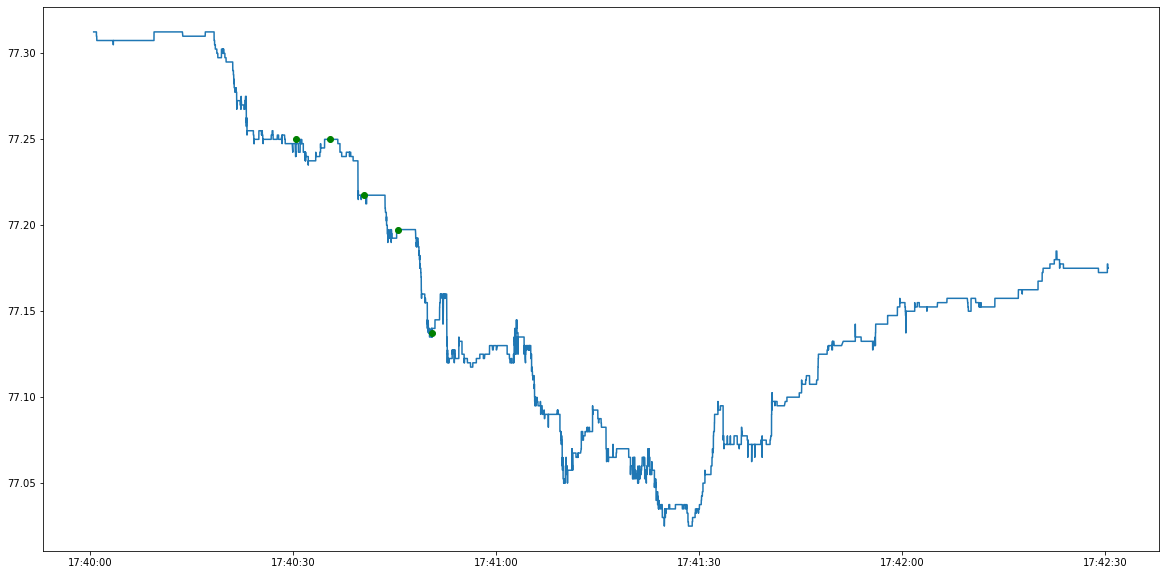

In [65]:
plt.figure(figsize=(20,10))
plt.plot(sub_period.Time, sub_period.ASK_PRICE1)
plt.plot(m1, p1,  'o', color='green')
plt.plot(m2, p2,  'o', color='green')
plt.plot(m3, p3,  'o', color='green')
plt.plot(m4, p4,  'o', color='green')
plt.plot(m5, p5,  'o', color='green')
#...